#python deep_dream.py path_to_your_base_image.jpg prefix_for_results
#python deep_dream.py img/mypic.jpg results/dream

#from __future__ import print_function


from tensorflow import keras

import numpy as np
import argparse

from keras.applications import inception_v3
from keras import backend as K
from keras.preprocessing import image


from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow import keras
from keras.applications import inception_v3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm
import scipy

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from scipy import stats

import tensorflow as tf


Using TensorFlow backend.


In [2]:
K.backend()

'tensorflow'

In [3]:
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet',include_top=False)
dream = model.input
print('Model loaded.')

Model loaded.


In [4]:
import os
import cav
working_dir = '/Users/tyler/Desktop/dissertation/programming/tcav_on_azure'

concept = 'grid_sub_1'
cav_dict = {}
layer_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
#layer_names = ['mixed0']
for layer_name in layer_names:
    subpath = concept + '-random500_0-' + layer_name
    cav_path = 'cav_dir/' + subpath + '-linear-0.1.pkl'
    path = os.path.join(working_dir, cav_path)
    this_cav = cav.CAV.load_cav(path)
    cav_dict[layer_name] = this_cav.cavs[0]
    
'''
concept = 'striped_sub_1'
layer_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
layer_names = ['mixed6']
for layer_name in layer_names:
    subpath = concept + '-random500_0-' + layer_name
    cav_path = 'cav_dir/' + subpath + '-linear-0.1.pkl'
    path = os.path.join(working_dir, cav_path)
    this_cav = cav.CAV.load_cav(path)
    cav_dict[layer_name] = this_cav.cavs[0]
'''

"\nconcept = 'striped_sub_1'\nlayer_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']\nlayer_names = ['mixed6']\nfor layer_name in layer_names:\n    subpath = concept + '-random500_0-' + layer_name\n    cav_path = 'cav_dir/' + subpath + '-linear-0.1.pkl'\n    path = os.path.join(working_dir, cav_path)\n    this_cav = cav.CAV.load_cav(path)\n    cav_dict[layer_name] = this_cav.cavs[0]\n"

In [5]:
#cav_dict

In [76]:
step = 0.02  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.3  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 100000000


#result_prefix = '/home/tyler/Desktop/tcav_on_azure/results/test'

size_dict = {'mixed0': 313600,'mixed1': 352800,'mixed2': 352800,'mixed3': 221952,'mixed4': 221952,'mixed5': 221952,'mixed6': 221952,'mixed7': 221952,'mixed8': 81920,'mixed9': 131072,'mixed10': 131072}

settings = {
    'features': {
        #'mixed0': 1,#/313600,
        #'mixed1': 1,#/352800,
        #'mixed2': 1,#/352800,
        #'mixed3': 1,#/221952,
        'mixed4': 1,#/221952,
        #'mixed5': 1,#/221952,
        #'mixed6': 5,#/221952,
        #'mixed7': 1,#/221952,
        #'mixed8': 1,#/81920,
        #'mixed9': 1,#/131072,
        #'mixed10': 0#/131072
    },}

In [77]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

sess = K.get_session()

loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling
        
        
loss -= .000003 * K.sum(K.abs(dream))


# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        if i % 5 == 0:
            print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

## With Scaling

In [78]:
base_image_path = os.path.join(working_dir,'concepts/noise_white/img1.jpg')
#base_image_path = os.path.join(working_dir,'concepts/noise_white/img1.jpg')
#base_image_path = os.path.join(working_dir,'sky.jpg')

jitter_setting = 0

In [79]:
tf.logging.set_verbosity(0)

img_pic = image.load_img(base_image_path, target_size=(299, 299))
#img = image.img_to_array(img_pic)
img = preprocess_image(base_image_path)
img = resize_img(img,(299,299,3))
#img = np.expand_dims(img, axis=0) / 255

jitter =  2*(np.random.random((img.shape[1], img.shape[2], 3)) - 0.5) * jitter_setting
jitter = np.expand_dims(jitter, axis=0)
img += jitter
    
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    x,y = shape
    if x < 400 and y < 400:
        successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)

    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
img -= jitter
save_img(img, fname='results/test_1.png')

Processing image shape (176, 176)
..Loss value at 0 : -0.19899926
..Loss value at 5 : -0.03183259
..Loss value at 10 : 0.4021224
..Loss value at 15 : 0.8068146
Processing image shape (230, 230)
..Loss value at 0 : -0.21285436
..Loss value at 5 : 0.7805238
..Loss value at 10 : 1.4350188
..Loss value at 15 : 2.0343366
Processing image shape (299, 299)
..Loss value at 0 : -0.4241344
..Loss value at 5 : 0.8959777
..Loss value at 10 : 1.8393558
..Loss value at 15 : 2.5616472


In [80]:
#img

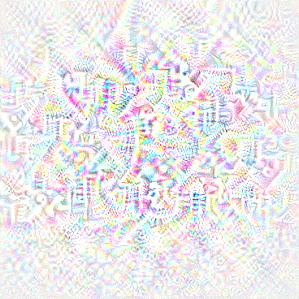

In [81]:
#img_path = 'concepts/striped_sub_1/striped_0004.jpg'
img_path = 'results/test_1.png'
show_img = image.load_img(img_path)
show_img

In [ ]:
#decode_predictions(preds, top=3)

In [ ]:
model = load_model('v3_model.h5')

In [ ]:
#get_prediction(prep(img_path))
preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: prep(img_path)})

In [ ]:
preds.shape

In [ ]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

In [11]:
def get_prediction(img):
    img = preprocess_input(img)
    preds = sess.run(endpoints_v3['prediction'], {endpoints_v3['input']: img})
    top = decode_predictions(preds, top=3)
    return top

def prep(path):
    img_pic = image.load_img(path, target_size=(299, 299))
    img = image.img_to_array(img_pic)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
#save_img(img, fname='results/zebra/0_1_2_3.png')

In [ ]:
#show_img = image.load_img('results/striped_7_8_9.png', target_size=(299, 299))
#show_img

In [ ]:
img_pic

In [ ]:
#img_in = image.load_img(base_image_path, target_size=(299, 299))
# 1. run model
# 2. run bottlenecks_tensors
# 3. sess = K.get_session()
img = preprocess_image(base_image_path)
bottleneck_name = 'mixed9'
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
#layer_9_acts.shape

In [ ]:
img.shape

In [ ]:
successive_shapes
img = resize_img(img, shape)

In [ ]:
img.shape

In [ ]:
#img = preprocess_image(base_image_path)
bottleneck_name = 'mixed9'
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
layer_9_acts.shape

In [ ]:
img.shape

In [ ]:
img = gradient_ascent(img,
                      iterations=iterations,
                      step=step,
                      max_loss=max_loss)

In [ ]:
x = img
eval_loss_and_grads(x)

In [ ]:
layer_cav = K.constant(cav_dict[layer_name].reshape(-1,1))
n = layer_cav.shape[0]
print(n, layer_name)
#n_tensor = K.constant(n.value/1000)

coeff = settings['features'][layer_name]
acts = layer_dict[layer_name].output
#flat_acts = K.variable(K.reshape(acts,(1,n)))

#loss_2 += coeff * K.dot(K.reshape(acts,(1,n)),layer_cav) / n_tensor

In [ ]:
acts

In [ ]:
acts_sq = K.squeeze(acts,axis = 1)

In [ ]:
acts_sq

In [ ]:
flat_acts

In [ ]:
layer_cav

In [ ]:
K.slice(acts)

In [ ]:
layer_cav

In [ ]:
layer_dict['mixed9'].output

In [ ]:
cav_dict['mixed9'].shape[0]

In [ ]:
cav_dict['mixed9'].shape[0] / 2048

In [ ]:
x / 288

In [ ]:
model.layers.o

In [ ]:
layer_cav.set_shape(acts.shape)

In [ ]:
#image.img_to_array(img_pic)

In [ ]:
## No scaling

In [ ]:
tf.logging.set_verbosity(0)

base_image_path = 'concepts/striped_sub_1/striped_0004.jpg'
base_image_path = '/home/tyler/Desktop/tcav_on_azure/concepts/noise_white/img1.jpg'

img_pic = image.load_img(base_image_path, target_size=(299, 299))
img = image.img_to_array(img_pic)
img = np.expand_dims(img, axis=0)
img = inception_v3.preprocess_input(img)

jitter =  2*(np.random.random((img.shape[1], img.shape[2], 3)) - 0.5) * .05
jitter = np.expand_dims(jitter, axis=0)
img += jitter

#original_img = np.copy(img)
img = gradient_ascent(img,iterations=iterations,step=step,max_loss=max_loss)

img -= jitter

img_name = 'placeholder'
save_img(img, fname='results/' + img_name + '.png')

In [ ]:
    #flat_act = np.reshape(np.asarray(acts).squeeze(), -1)
    #flat_act_norm = keras.utils.normalize(flat_act)
    #loss2 = euclidean_distance(vec_norm(layer_9_cav),flat_act_norm)
    
    #loss_2 += K.sum(K.square(K.reshape(acts,(131072,)) - layer_9_cav_K))
    #loss_2 += K.dot(K.reshape(acts,(1,131072)),K.transpose(layer_9_cav_K))

In [ ]:
layer_name = 'mixed9'
layer_out = layer_dict[layer_name].output

In [ ]:
layer_out

In [ ]:
img_in = shrunk_original_img

In [ ]:
img_in.shape

In [ ]:
new_acts = fetch_loss_and_grads_2([img_in])[0]

In [ ]:
new_acts

In [ ]:
layer_9_acts[0][5][0]

In [ ]:
new_acts[0][5][0]

## New Loss

In [ ]:
def get_loss(this_img):
    layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: this_img})
    flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)
    loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))
    
    return loss

In [ ]:
get_loss(original_img)

In [ ]:
original_img.shape

In [ ]:
sess = K.get_session()
#my_graph = tf.get_default_graph()


In [ ]:
#my_graph.get_collection()

In [ ]:
sess

In [ ]:
model.input

In [ ]:
this_img = original_img

loss = K.variable(0.)
layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{model.input: this_img})
flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)
loss += euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

#K.clear_session()

In [ ]:
layer_9_acts = layer_dict[layer_name].output

In [ ]:
layer_9_acts

In [ ]:
x.shape

In [ ]:
sess.run(bottlenecks_tensors[bottleneck_name],
                         {self.ends['input']: examples})

In [ ]:
#sess.run(bottlenecks_tensors[bottleneck_name],{model.input: img})

In [ ]:
#layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: img})

#flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

In [ ]:
#layer_9_acts = sess.run(bottlenecks_tensors[bottleneck_name],{endpoints_v3['input']: x})

#flat_act = np.reshape(np.asarray(layer_9_acts).squeeze(), -1)

#euclidean_distance(vec_norm(layer_9_cav),vec_norm(flat_act))

## Static functions

In [10]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def euclidean_distance(a,b):
    return np.linalg.norm(a-b)

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

def get_bottleneck_tensors():
    """Add Inception bottlenecks and their pre-Relu versions to endpoints dict."""
    graph = tf.get_default_graph()
    bn_endpoints = {}
    for op in graph.get_operations():
        # change this below string to change which layers are considered bottlenecks
        # use 'ConcatV2' for InceptionV3
        # use 'MaxPool' for VGG16 (for example)
        if 'ConcatV2' in op.type:
            name = op.name.split('/')[0]
            bn_endpoints[name] = op.outputs[0]

    return bn_endpoints

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],
)

bottlenecks_tensors = get_bottleneck_tensors()
bottleneck_name = 'mixed9'

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def eu_distance(A,B):
    return K.sum(K.abs(A-B),axis=1,keepdims=True)



#Process:
# Load the original image.
# Define a number of processing scales (i.e. image shapes), from smallest to largest.
# Resize the original image to the smallest scale.
# For every scale, starting with the smallest (i.e. current one):
    # Run gradient ascent
    # Upscale image to the next scale
    # Reinject the detail that was lost at upscaling time
# Stop when we are back to the original size.
#To obtain the detail lost during upscaling, we simply take the original image, shrink it down, upscale it,
# and compare the result to the (resized) original image.